# <center> GRANITES CLASSIFICATION

In [84]:
###################################################################################################
#                                  Bibliotecas usadas no notebook                                 #
###################################################################################################
#utilitários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from itertools import combinations
from sklearn.metrics import RocCurveDisplay

#Pré processamento
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

#Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#SMOTE
from imblearn.over_sampling import SMOTE

#Bayesian Optimization
from bayes_opt import BayesianOptimization

#Avaliadores
from sklearn.metrics import f1_score, precision_score, recall_score, \
    classification_report, accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, \
    roc_curve, auc

from sklearn.utils import compute_sample_weight
from sklearn.model_selection import cross_val_score
import shap

#salvar e carregar modelos treinados
import joblib

#filtrando alertas
import warnings
warnings.filterwarnings("ignore")
xgb.set_config(verbosity=0)

#parâmetros para o matplotlib
plt.rcParams.update({'font.size': 14, 'axes.grid': False, 'xtick.bottom':True })
sns.set_style("ticks")

In [2]:
###################################################################################################
#                                 funções usadas no notebook                                      #
###################################################################################################

def treino_de_classificadores(classificadores, X_treino, y_treino, pesos=None):
    '''Função de treino de classificadores e métricas'''
    for classificador in classificadores:
        classificador.fit(X_treino, np.ravel(y_treino), sample_weight=pesos)
        y_previsao = cross_val_predict(classificador, X_treino, y_treino, cv=10)
        precisao = precision_score(y_treino, y_previsao, average = 'weighted')
        revocacao = recall_score(y_treino, y_previsao, average = 'weighted')
        pontuacao_f1 = f1_score(y_treino, y_previsao, average = 'weighted')
        print(classificador.__class__.__name__)
        print(f'precisão:{precisao}, revocação:{revocacao}, F1 score: {pontuacao_f1}')
        
def metricas_score(modelos, X_teste, y_teste, imb_treatment='No_treatment'): #imb_treatment
    '''Avialia modelos treinados com base em diferentes métricas'''
    metricas_modelo = {}
    for indice, modelo in enumerate(modelos):
        nome = modelo.__class__.__name__
        previsao = modelo.predict(X_teste)
        previsao_proba = modelo.predict_proba(X_teste)
        f1 = f1_score(y_teste, previsao, average='macro')
        precisao = precision_score(y_teste, previsao, average='macro')
        roc = roc_auc_score(y_teste, previsao_proba, multi_class='ovo')
        acuracia = accuracy_score(y_teste, previsao)
        imb_treatment = imb_treatment

        metricas_modelo[indice] = nome, roc,f1, acuracia, precisao, imb_treatment
        
        
    return pd.DataFrame.from_dict(metricas_modelo, orient='index', columns=['Modelo','AUC' ,'F1', 'Acurácia', 'Precisão', 'imb_treatment'])

## <center> LOADING AND PREPARING DATA

In [3]:
#Carregando o database tratado
database = pd.read_csv('dataset/GDB_Bonin(2020)_update.csv')

#Separando variáveis preditoras e variável alvo

database_preditores = database[['SiO2', 'TiO2', 'Al2O3','FeOt', 'MnO', 'MgO', 'CaO', 
                                'K2O', 'Na2O']]

database_alvo = database[['Group']]

## <center> EXPLORATORY DATA ANALYSIS

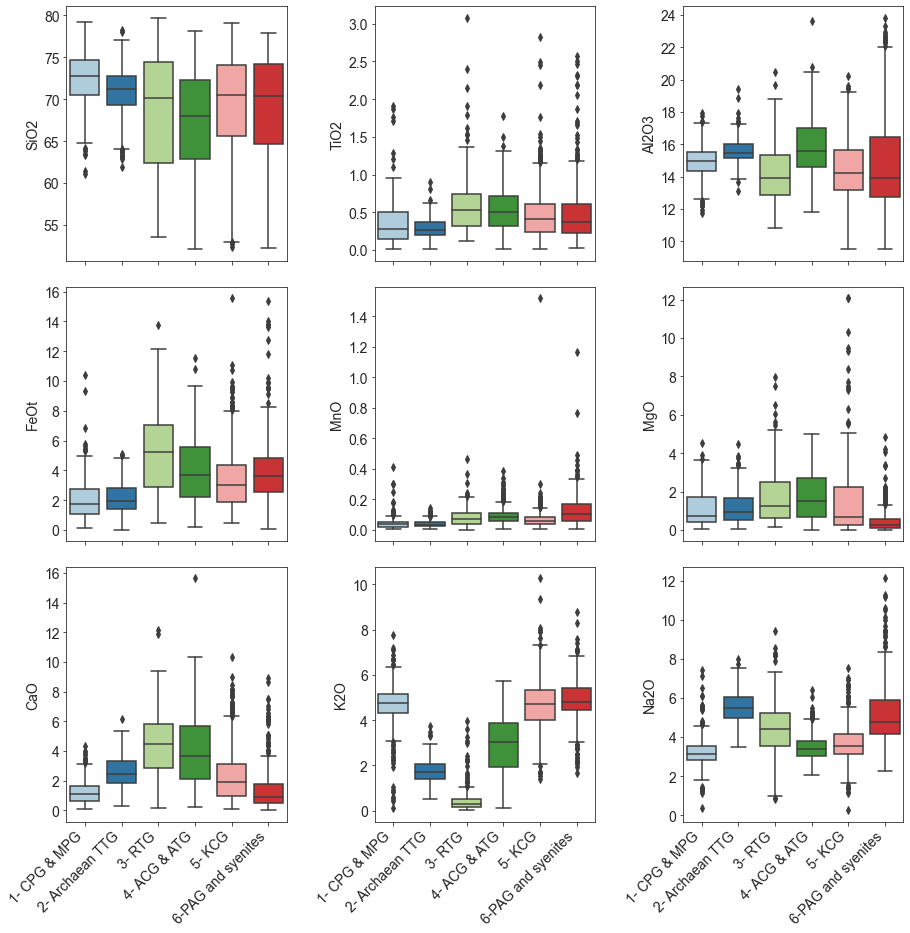

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(15,15))
plt.subplots_adjust(wspace=0.40, hspace=0.1)

contagem = 0
for i in range(0,2):
    for j in range(0,3):
        sns.boxplot(ax=axes[i, j], data=database_preditores, x=database_alvo['Group'], 
                    y=database_preditores.columns[contagem], palette="Paired", order=['1- CPG & MPG', '2- Archaean TTG', '3- RTG', '4- ACG & ATG',
       '5- KCG', '6-PAG and syenites'])
        contagem += 1       

for i in range(0,3):
    axes[0,i].set_xticklabels("", rotation=45, ha='right')
for i in range(0,3):
    axes[1,i].set_xticklabels("", rotation=45, ha='right')
    
for i in range(2,3):
    for j in range(0,3):
        sns.boxplot(ax=axes[i, j], data=database_preditores, x=database_alvo['Group'], 
                    y=database_preditores.columns[contagem], palette="Paired", order=['1- CPG & MPG', '2- Archaean TTG', '3- RTG', '4- ACG & ATG',
       '5- KCG', '6-PAG and syenites'])
        contagem += 1        
for i in range(0,3):
    axes[2,i].set_xticklabels(axes[2,i].get_xticklabels(), rotation=45, ha='right')
    
plt.setp(axes, xlabel=None);
plt.savefig('boxplot.jpeg', bbox_inches='tight')

# <center> PRE PROCESSING DATA

In [6]:
#Realizando um amostragem estratificada
X_train, X_test, y_train, y_test = train_test_split(database_preditores, database_alvo, 
                                                    test_size=0.30, stratify=database_alvo, random_state=42)

scaler = StandardScaler()
encoder = LabelEncoder()
X_train_scaled = scaler.fit_transform(X_train)
y_train_encoded = encoder.fit_transform(y_train)

# SMOTE
smote = SMOTE()
scaler_smt = StandardScaler()
encoder_smt = LabelEncoder()

X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train)
X_train_smt_scaled = scaler_smt.fit_transform(X_train_smt)
y_train_smt_encoded = encoder_smt.fit_transform(y_train_smt)

# <center> TRAINING BASE MODELS

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_clf = LinearDiscriminantAnalysis(n_components=3)
lda_model = lda_clf.fit(X_train_scaled, y_train_encoded).transform(X_train_scaled)

models_base = [lda_clf]
X_test_scaled = scaler.transform(X_test)
y_test_encoded = encoder.transform(y_test)


metricas_modelos = metricas_score(models_base, X_test_scaled, y_test_encoded, 'lda')
metricas_modelos

In [ ]:
plt.subplots(figsize=(10,10))
sns.scatterplot(x=lda_model[:,0], y=lda_model[:,1], hue=y_train_encoded, palette="deep")
plt.legend(loc='upper left')
sns.set_style("whitegrid");


# <center> TRAINING AND TESTING THE BEST MODELS

In [ ]:
# Base Models
rf = RandomForestClassifier(random_state=42)
xgb_clf = XGBClassifier(random_state=42)
lgbm = LGBMClassifier(random_state=42)

modelos_base = [rf, xgb_clf, lgbm]
treino_de_classificadores(modelos_base, X_train_scaled, y_train_encoded);

In [ ]:
#Best Models

best_rf = RandomForestClassifier(max_depth=10.0, max_features=4, 
                                 min_samples_split=4, n_estimators=150, 
                                 random_state=42)

best_xgb = XGBClassifier(colsample_bylevel=0.5,
              colsample_bynode=0.5, colsample_bytree=0.999,
              enable_categorical=False, learning_rate=0.1, max_delta_step=None, max_depth=6,
              n_estimators=193, scale_pos_weight=None, subsample=0.5, verbosity=None, random_state=42)


best_lgbm = LGBMClassifier(colsample_bytree=0.5, max_depth=9,
                           n_estimators=141,subsample=0.999, random_state=42)

modelos_best = [best_rf, best_xgb, best_lgbm]
#pesos = compute_sample_weight("balanced", y_train_encoded)
treino_de_classificadores(modelos_best, X_train_scaled, y_train_encoded);

In [ ]:
# Best models + SMOTE
best_rf_sm = RandomForestClassifier(max_depth=10, max_features=4, min_samples_split=4, 
                                    n_estimators=100, random_state=42)

best_xgb_sm = XGBClassifier(colsample_bylevel=0.5,
              colsample_bynode=0.5, colsample_bytree=0.999,
              enable_categorical=False, learning_rate=0.1, max_delta_step=None, max_depth=6,
              n_estimators=193, scale_pos_weight=None, subsample=0.5, verbosity=None,
                           random_state=42)


best_lgbm_sm = LGBMClassifier(colsample_bytree=0.5, max_depth=9,
                           n_estimators=141,subsample=0.999, random_state=42)


modelos_best_smote = [best_rf_sm, best_xgb_sm, best_lgbm_sm]
treino_de_classificadores(modelos_best_smote, X_train_smt_scaled, y_train_smt_encoded)

# Saving base models
joblib.dump(rf,'models/RF_base.joblib')
joblib.dump(xgb_clf,'models/XGB_base.joblib')
joblib.dump(lgbm ,'models/LGBM_base.joblib')

# Saving best models
joblib.dump(best_rf,'models/RF_opt.joblib')
joblib.dump(best_xgb,'models/XGB_opt.joblib')
joblib.dump(best_lgbm ,'models/LGBM_opt.joblib')

# Saving best + SMOTE models
joblib.dump(best_rf_sm,'models/RF_smote.joblib')
joblib.dump(best_xgb_sm,'models/XGB_smote.joblib')
joblib.dump(best_lgbm_sm ,'models/LGBM_smote.joblib')

# <center> TRAINING AND TESTING THE BEST MODELS (SMOTE)

# <center> MODEL EVALUATION

In [7]:
LGBM_base = joblib.load('models/LGBM_base.joblib')
XGBoost_base = joblib.load('models/XGB_base.joblib')
random_forest_base = joblib.load('models/RF_base.joblib')
LGBM = joblib.load('models/LGBM_opt.joblib')
XGBoost = joblib.load('models/XGB_opt.joblib')
random_forest = joblib.load('models/RF_opt.joblib')
LGBM_smote = joblib.load('models/LGBM_smote.joblib')
XGBoost_smote = joblib.load('models/XGB_smote.joblib')
random_forest_smote = joblib.load('models/RF_smote.joblib')

modelos_base = [LGBM_base , XGBoost_base, random_forest_base]
modelos_best = [LGBM, XGBoost, random_forest]
modelos_smote = [LGBM_smote, XGBoost_smote, random_forest_smote]

In [8]:
#scaling test variables
X_test_scaled, y_test_encoded = scaler.transform(X_test), encoder.transform(y_test)
X_test_scaled_smt, y_test_encoded_smt = scaler_smt.transform(X_test), encoder_smt.fit_transform(y_test)

#testing models
test_base = metricas_score(modelos_base, X_test_scaled, y_test_encoded, 'Base')
test_best = metricas_score(modelos_best, X_test_scaled, y_test_encoded, 'Best')
test_smote = metricas_score(modelos_smote, X_test_scaled_smt, y_test_encoded_smt, 'SMOTE')

In [9]:
metrics_all_models = pd.concat([test_base, test_best, test_smote]).reset_index(drop='index')
metrics_all_models

,Modelo,AUC,F1,Acurácia,Precisão,imb_treatment
0,LGBMClassifier,0.979449,0.871780,0.861814,0.877361,Base
1,XGBClassifier,0.979794,0.864866,0.858650,0.867306,Base
2,RandomForestClassifier,0.979657,0.852195,0.842827,0.854159,Base
3,LGBMClassifier,0.981170,0.876660,0.863924,0.885069,Best
4,XGBClassifier,0.980630,0.861700,0.854430,0.865995,Best
5,RandomForestClassifier,0.979036,0.854562,0.842827,0.860377,Best
6,LGBMClassifier,0.979021,0.859736,0.844937,0.860256,SMOTE
7,XGBClassifier,0.979572,0.853203,0.843882,0.852997,SMOTE
8,RandomForestClassifier,0.978582,0.841974,0.830169,0.839046,SMOTE


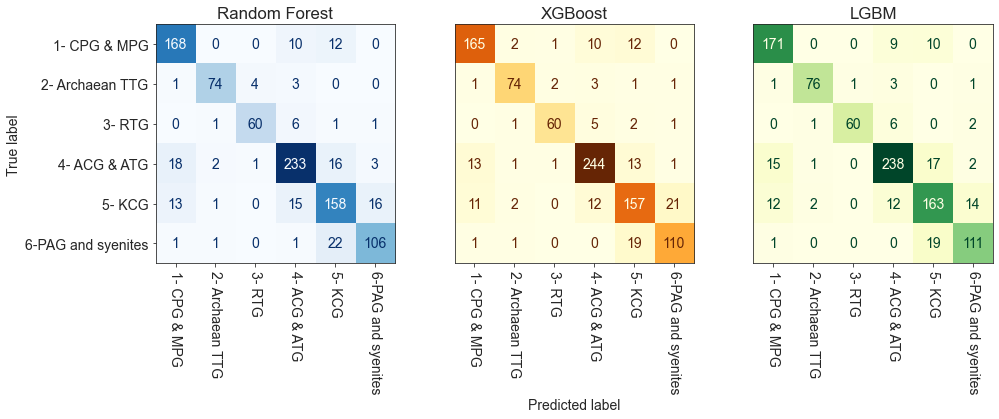

In [10]:
#predictions for test 
random_forest_predictions = random_forest.predict(X_test_scaled)
XGBboost_predictions = XGBoost.predict(X_test_scaled)
LGBM_predictions = LGBM.predict(X_test_scaled)

#confusion matrix
conf_matrix1 = confusion_matrix(y_test_encoded, random_forest_predictions)
conf_matrix2 = confusion_matrix(y_test_encoded, XGBboost_predictions)
conf_matrix3 = confusion_matrix(y_test_encoded, LGBM_predictions)

#Displaying confusion matrix for random forest test
fig, ax = plt.subplots(1,3,figsize=(15, 10))
ax[0].set_title("Random Forest")
ax[1].set_title("XGBoost")
ax[2].set_title("LGBM")
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)

cm = ConfusionMatrixDisplay(conf_matrix1,display_labels=encoder.classes_)
cm.plot(ax=ax[0], xticks_rotation=270,cmap='Blues', colorbar=False)
plt.setp(ax[0],xlabel=None)

# Displaying confusion matrix for XGBoost test
cm = ConfusionMatrixDisplay(conf_matrix2,display_labels=encoder.classes_)
cm.plot(ax=ax[1], xticks_rotation=270,cmap='YlOrBr', colorbar=False)
plt.setp(ax[1], yticks=[], ylabel=None)

# Displaying confusion matrix for ADABoost test
cm = ConfusionMatrixDisplay(conf_matrix3,display_labels=encoder.classes_)
cm.plot(ax=ax[2], xticks_rotation=270,cmap='YlGn', colorbar=False)
plt.setp(ax[2], yticks=[], ylabel=None ,xlabel=None)

plt.subplots_adjust(wspace=0.250, hspace=0.1)
#plt.show()
plt.savefig('confusion_matrix_best_models.jpeg', bbox_inches='tight')

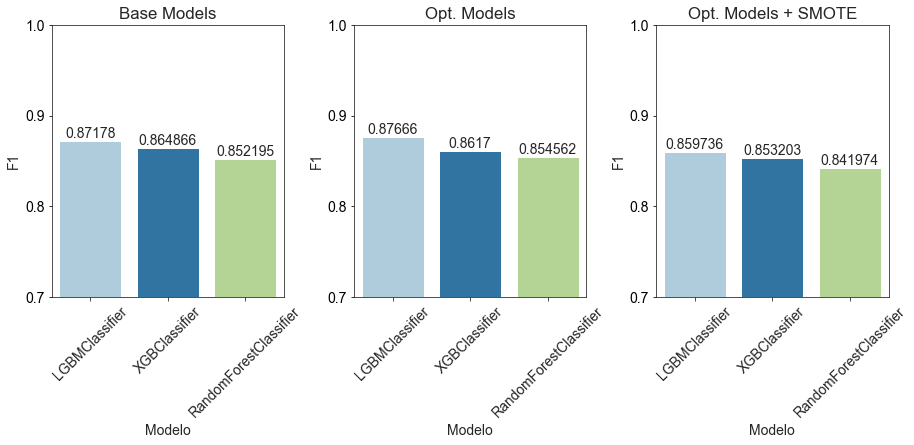

In [11]:
fig, ax = plt.subplots(1,3,figsize=(15, 5))
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)

ax[0] = sns.barplot(ax=ax[0], x=test_base['Modelo'], y=test_base['F1'], data=test_base, palette="Paired")
for container in ax[0].containers:
    ax[0].bar_label(container)
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].set_yticks([0.6,0.7,0.8,0.9,1])
ax[0].tick_params(axis='y', colors='black');
ax[0].set_ylim(0.7,1)

ax[1] = sns.barplot(ax=ax[1], x=test_best['Modelo'], y=test_best['F1'], data=test_best, palette="Paired")
for container in ax[1].containers:
    ax[1].bar_label(container)
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].set_yticks([0.7,0.8,0.9,1])
ax[1].tick_params(axis='y', colors='black');
ax[1].set_ylim(0.7, 1)

ax[2] = sns.barplot(ax=ax[2], x=test_smote['Modelo'], y=test_smote['F1'], data=test_smote, palette="Paired")
for container in ax[2].containers:
    ax[2].bar_label(container)
ax[2].tick_params(axis='x', labelrotation=45)
ax[2].set_yticks([0.7,0.8,0.9,1])
ax[2].tick_params(axis='y', colors='black');
ax[2].set_ylim(0.7, 1)

ax[0].set_title("Base Models")
ax[1].set_title("Opt. Models")
ax[2].set_title("Opt. Models + SMOTE")
plt.subplots_adjust(wspace=0.30, hspace=0.1)
plt.savefig('f1_scores.jpeg', bbox_inches='tight')

In [ ]:
explainer_rf = shap.TreeExplainer(best_rf)
shap_values_rf = explainer_xgb.shap_values(X_test_scaled)

shap.summary_plot(shap_values_rf, X_train_scaled, feature_names=X_train.columns,
                  class_names=encoder.classes_,class_inds='original',
                  color=plt.get_cmap("Paired"), show=False)
plt.title("SHAP Random Forest")
plt.savefig('shap_rf.jpeg', bbox_inches='tight')

In [ ]:
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_rf.shap_values(X_test_scaled)

shap.summary_plot(shap_values_xgb, X_train_scaled, feature_names=X_train.columns,
                  class_names=encoder.classes_,class_inds='original',
                  color=plt.get_cmap("Paired"), show=False)
plt.title("SHAP XGBoost")
plt.savefig('shap_xgb.jpeg', bbox_inches='tight')

In [ ]:
explainer_lgbm = shap.TreeExplainer(best_lgbm)
shap_values_lgbm = explainer_lgbm.shap_values(X_test_scaled)

shap.summary_plot(shap_values_lgbm, X_train_scaled, feature_names=X_train.columns,
                  class_names=encoder.classes_,class_inds='original',
                  color=plt.get_cmap("Paired"), show=False)
plt.tight_layout()
plt.title("SHAP LGBM")
plt.savefig('shap_lgbm.jpeg', bbox_inches='tight')

# <center> ROC AUC

In [14]:
random_forest_pred_proba = random_forest.predict_proba(X_test_scaled)
XGBboost_pred_proba = XGBoost.predict_proba(X_test_scaled)
LGBM_pred_proba = LGBM.predict_proba(X_test_scaled)

In [16]:
roc_auc_score(y_test_encoded, LGBM_pred_proba, multi_class='ovo')

0.9811699161073164

In [17]:
roc_auc_score(y_test_encoded, LGBM_pred_proba, multi_class='ovr', average='macro')

0.9796832913486497

In [20]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

In [21]:
label_binarizer.classes_

array(['1- CPG & MPG', '2- Archaean TTG', '3- RTG', '4- ACG & ATG',
       '5- KCG', '6-PAG and syenites'], dtype='<U18')

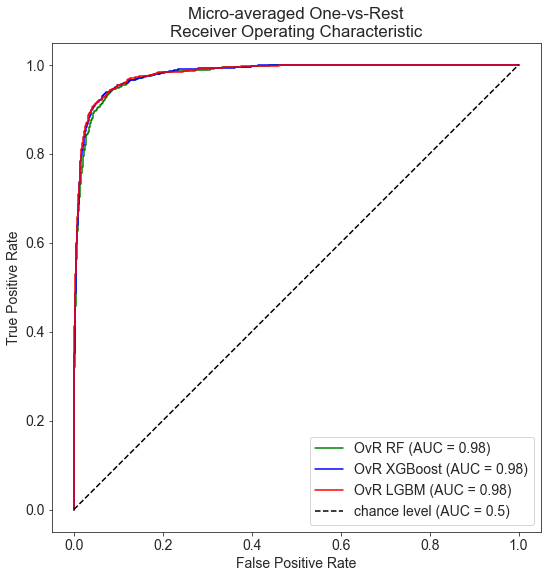

In [105]:
fig, ax = plt.subplots(figsize=(9,9))

RocCurveDisplay.from_predictions(
        y_onehot_test.ravel(),
        random_forest_pred_proba.ravel(),
        name="OvR RF",
        color="green", ax=ax,)

RocCurveDisplay.from_predictions(
        y_onehot_test.ravel(),
        XGBboost_pred_proba.ravel(),
        name="OvR XGBoost",
        color="blue", ax=ax)

RocCurveDisplay.from_predictions(
        y_onehot_test.ravel(),
        LGBM_pred_proba.ravel(),
        name="OvR LGBM",
        color="red", ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.savefig('fig_' + 'ROC_OvR_' + '.jpeg', bbox_inches='tight', dpi=600)

In [23]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), LGBM_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.3f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.982


In [24]:
n_classes = len(np.unique(y_train))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], LGBM_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


Macro-averaged One-vs-Rest ROC AUC score:
0.980


Text(0.5, 0, 'False Positive Rate')

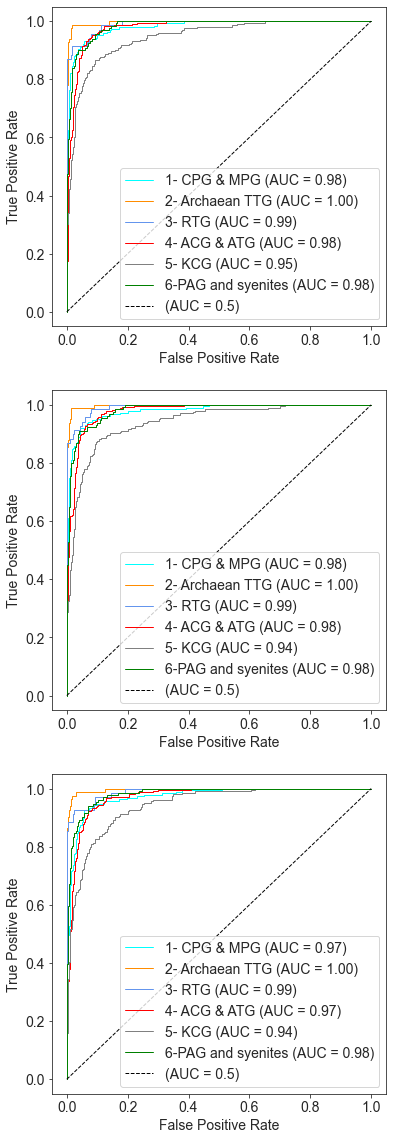

In [211]:
###################################################################################################
#                                       ROC para 1 classe vs Resto                                #
###################################################################################################
#tentando colocar os3 lado a lado...

fig, ax = plt.subplots(3,1,figsize=(6, 20))


colors = cycle(["aqua", "darkorange", "cornflowerblue", 'red', 'gray', 'green'])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        LGBM_pred_proba[:, class_id],
        color=color,
        name=f"{encoder.classes_[class_id]}",
        ax=ax[0], linewidth=1
    )
    
colors = cycle(["aqua", "darkorange", "cornflowerblue", 'red', 'gray', 'green'])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        XGBboost_pred_proba[:, class_id],
        color=color,
        name=f"{encoder.classes_[class_id]}",
        ax=ax[1], linewidth=1
    )
    
colors = cycle(["aqua", "darkorange", "cornflowerblue", 'red', 'gray', 'green'])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        random_forest_pred_proba[:, class_id],
        color=color,
        name=f"{encoder.classes_[class_id]}",
        ax=ax[2], linewidth=1)

ax[0].plot([0, 1], [0, 1], "k--", label="(AUC = 0.5)", linewidth=1), ax[0].legend()
ax[0].set_ylabel("True Positive Rate")
ax[0].set_xlabel("False Positive Rate")
ax[1].plot([0, 1], [0, 1], "k--", label="(AUC = 0.5)", linewidth=1), ax[1].legend()
ax[1].set_ylabel("True Positive Rate")
ax[1].set_xlabel("False Positive Rate")
ax[2].plot([0, 1], [0, 1], "k--", label="(AUC = 0.5)", linewidth=1), ax[2].legend()
ax[2].set_ylabel("True Positive Rate")
ax[2].set_xlabel("False Positive Rate")



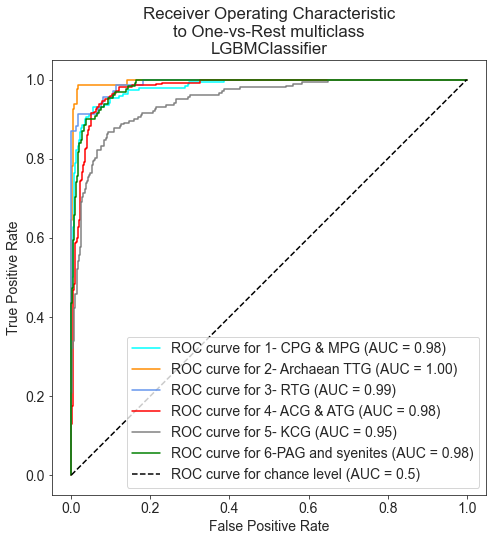

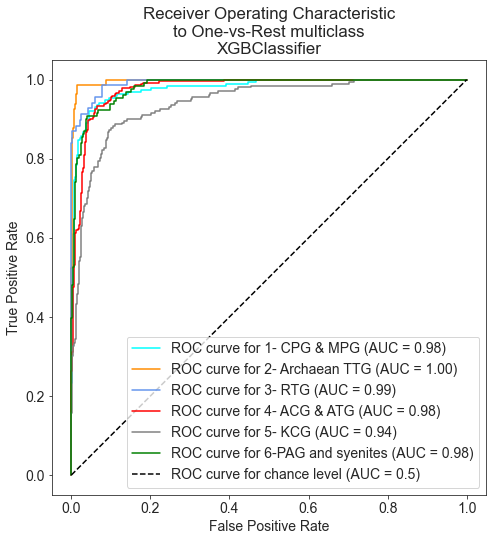

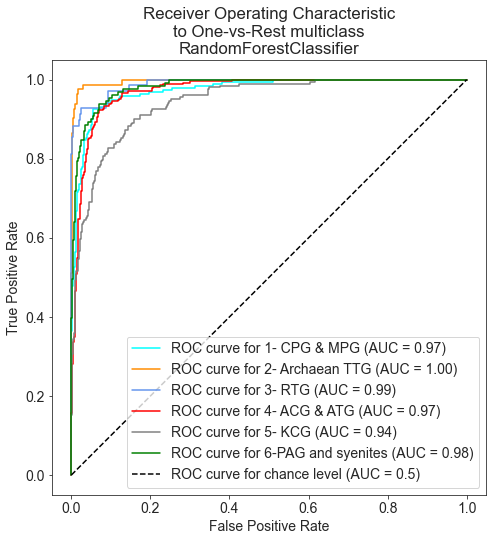

In [112]:
###################################################################################################
#                          ROC para 1 classe vs Resto (Todos os modelos)                          #
###################################################################################################

for modelo in modelos_best: 
    fig, ax = plt.subplots(figsize=(8, 8))
    n_classes = len(np.unique(y_train))
    modelo_pred_proba = modelo.predict_proba(X_test_scaled)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], modelo_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    colors = cycle(["aqua", "darkorange", "cornflowerblue", 'red', 'gray', 'green'])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            modelo_pred_proba[:, class_id],
            name=f"ROC curve for {encoder.classes_[class_id]}",
            color=color,
            ax=ax,
        )

        
    nome_modelo = "Receiver Operating Characteristic\nto One-vs-Rest multiclass\n" + modelo.__class__.__name__
    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(nome_modelo)
    plt.legend()
    plt.show()
    

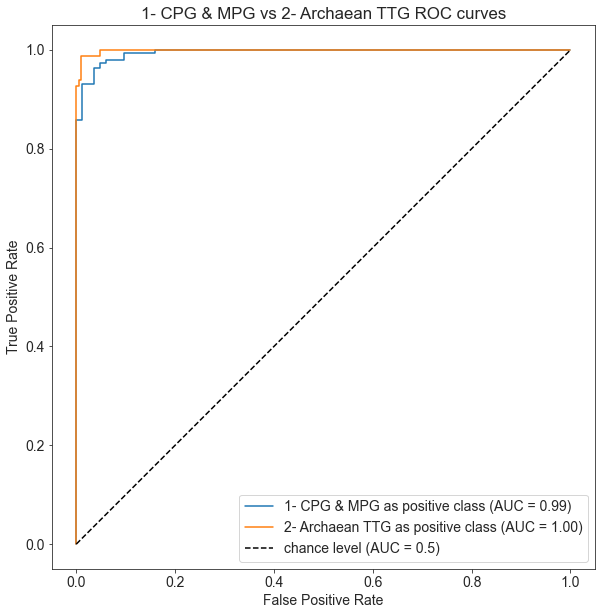

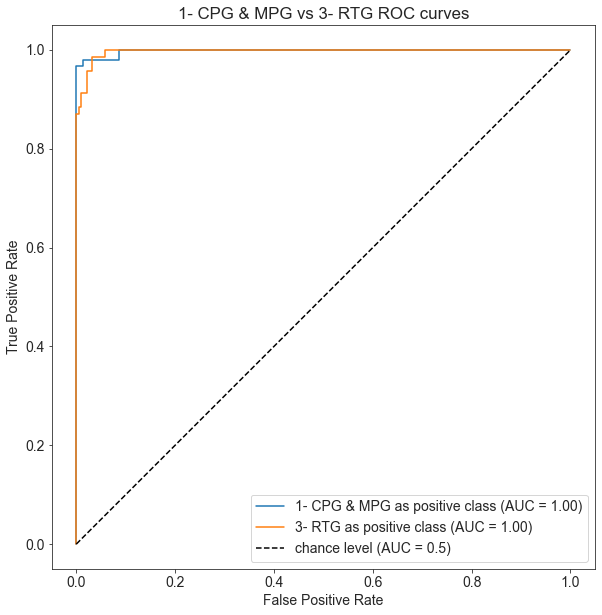

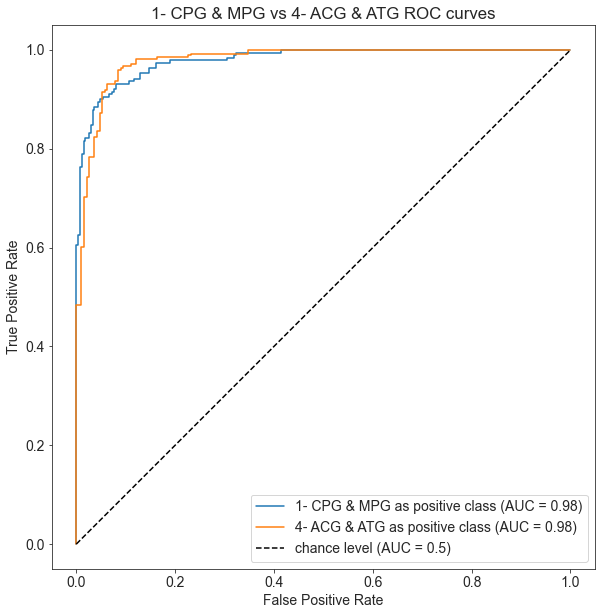

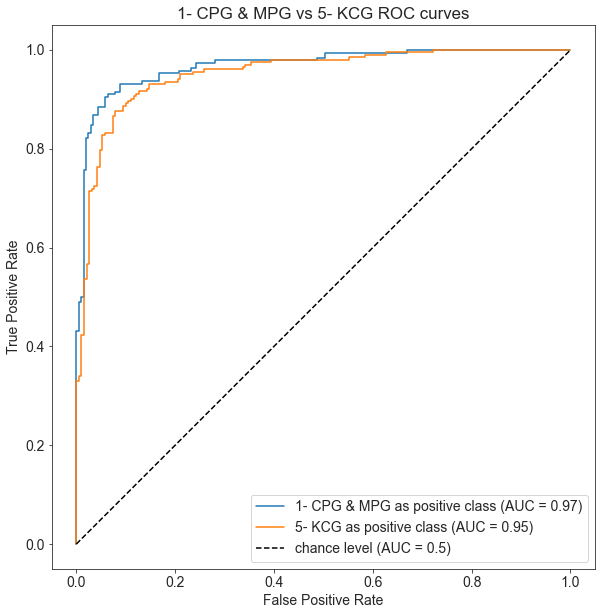

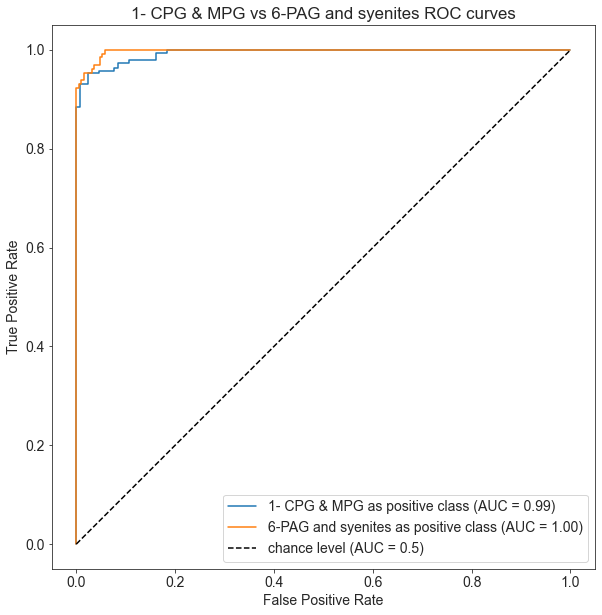

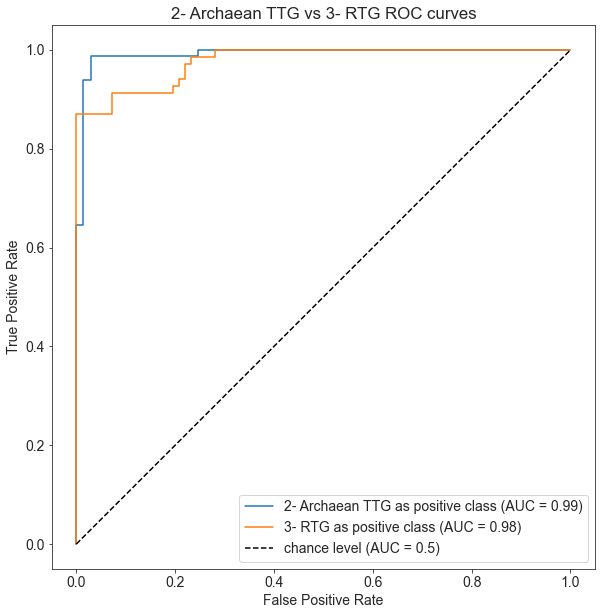

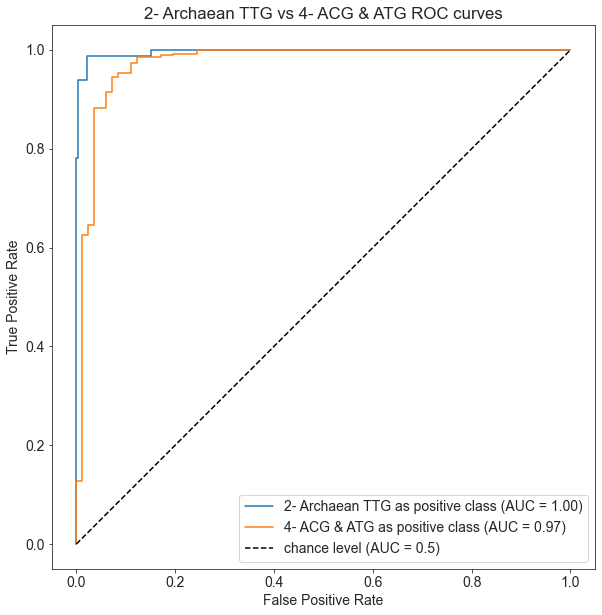

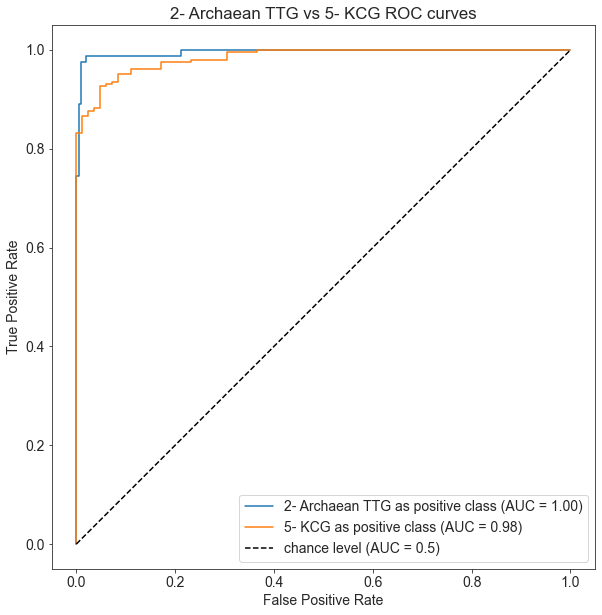

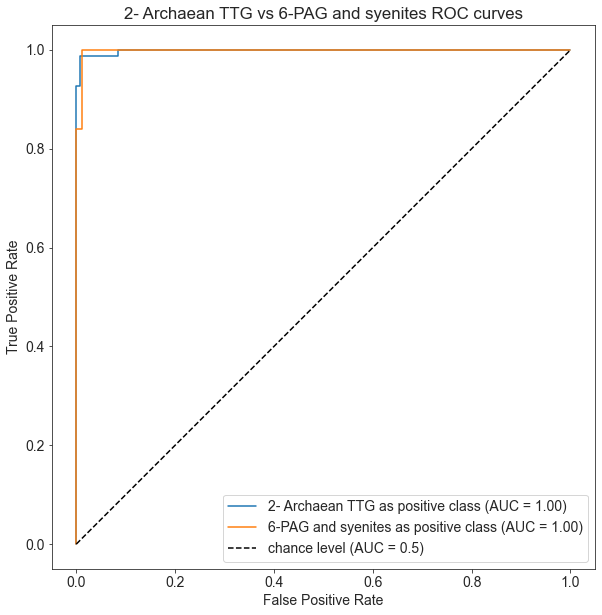

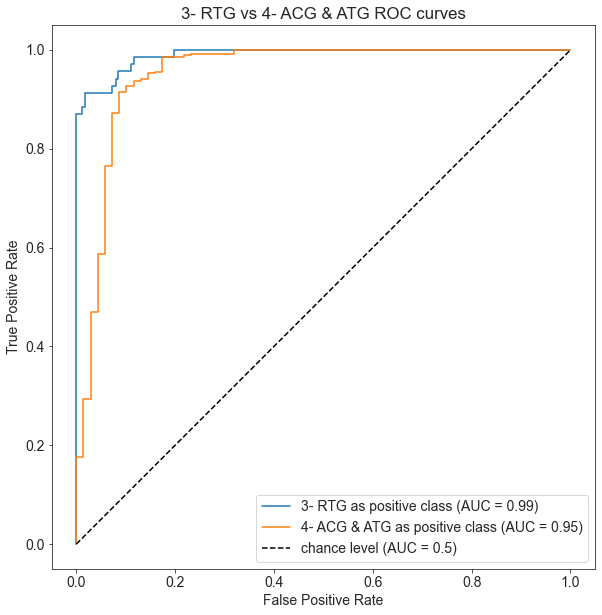

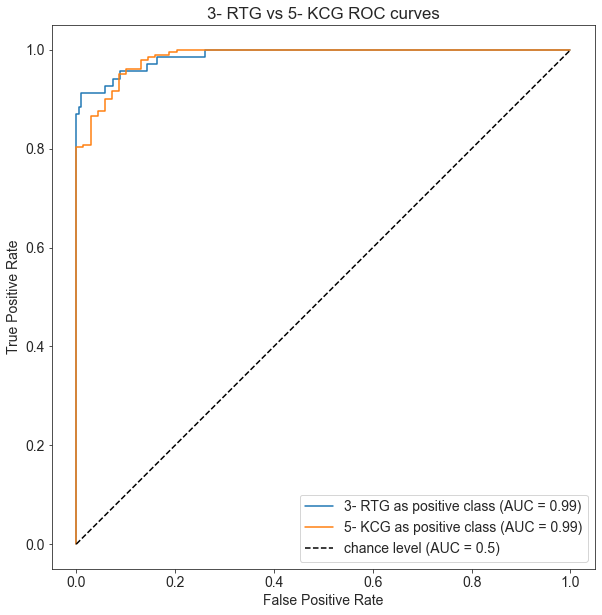

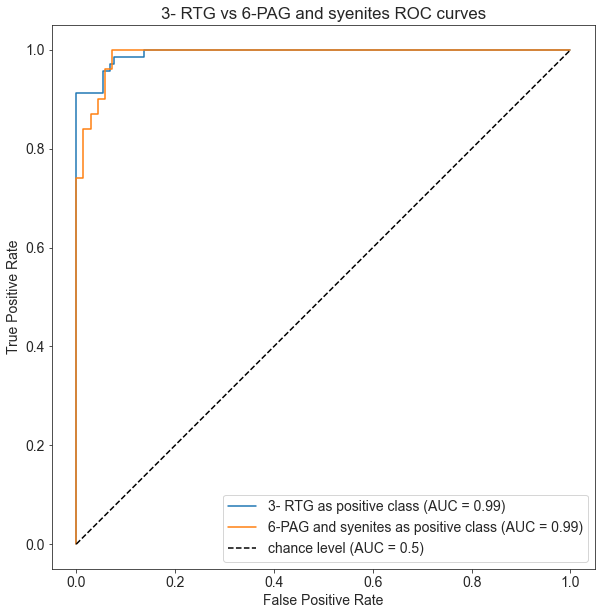

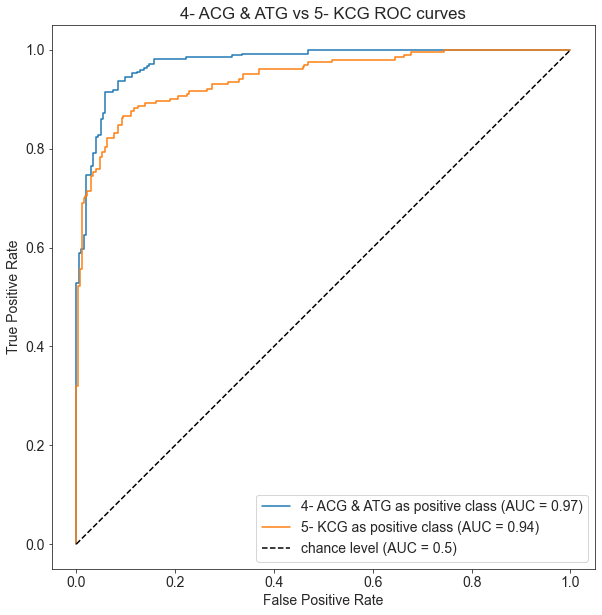

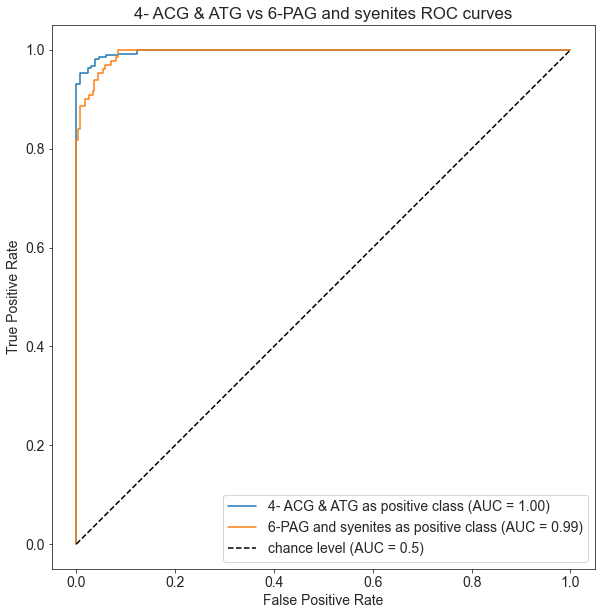

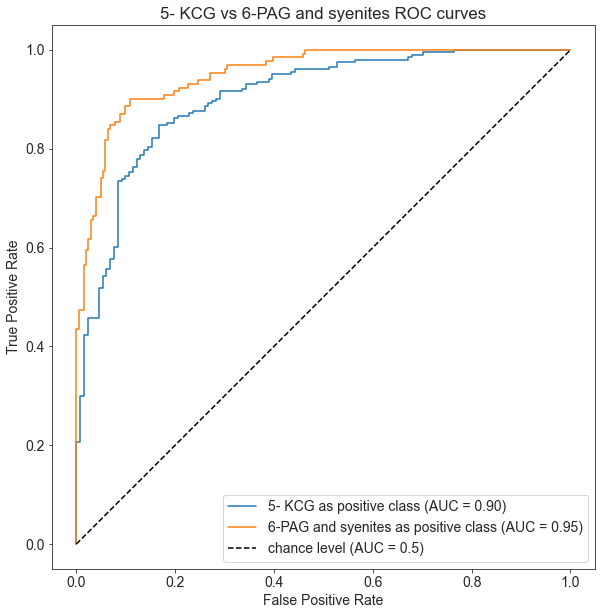

In [86]:
pair_list = list(combinations(np.unique(y_train), 2))
pair_scores = []
mean_tpr = dict()

for ix, (label_a, label_b) in enumerate(pair_list):

    a_mask = np.ravel(y_test == label_a)
    b_mask = np.ravel(y_test == label_b)
    ab_mask = np.ravel(np.logical_or(a_mask, b_mask))

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(np.ravel(a_true), LGBM_pred_proba[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(np.ravel(a_true), LGBM_pred_proba[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

    fig, ax = plt.subplots(figsize=(10, 10))

    RocCurveDisplay.from_predictions(
        a_true,
        LGBM_pred_proba[ab_mask, idx_a],
        ax=ax,
        name=f"{label_a} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        LGBM_pred_proba[ab_mask, idx_b],
        ax=ax,
        name=f"{label_b} as positive class",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{label_binarizer.classes_[idx_a]} vs {label_b} ROC curves")
    plt.legend()
    plt.savefig('fig' + str(ix) + '.jpeg', bbox_inches='tight')